In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.pipeline import Pipeline
import re
import nltk
import string
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [ ]:
import nltk
import subprocess
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...


In [ ]:
lm = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv")

In [ ]:
df=df.sample(5000,random_state=42)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 33553 to 20382
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [ ]:
df=df.dropna()

In [ ]:
def transform_data(review):
        review = review.lower()
        review = re.sub('^a-zA-Z0-9',' ',review)
        review = re.sub('<.*?>',' ',review)
        review = "".join([x for x in review if x not in string.punctuation])
        review = review.split()
        review =[lm.lemmatize(x) for x in review if x not in stop_words]
        review = " ".join(review)
        return review

tranformed_rev = df.review.apply(transform_data)

In [ ]:
df.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


In [ ]:
tranformed_rev

33553    really liked summerslam due look arena curtain...
9427     many television show appeal quite many differe...
199      film quickly get major chase scene ever increa...
12447    jane austen would definitely approve one gwyne...
39489    expectation somewhat high went see movie thoug...
                               ...                        
39885    one eastwoods best movie separated western goo...
17566    blurred childhood memory kept echo cult serie ...
16062    love zombiemovies love amateurproductions meat...
48445    chan new york get involved attempt sabotage ne...
20382    wife thought film watereddown madefortv bbc ve...
Name: review, Length: 5000, dtype: object

## Data Visualization

In [ ]:
transformed_data = pd.DataFrame({"t_rev":tranformed_rev,"sentiment":df['sentiment']})

In [ ]:
transformed_data

,t_rev,sentiment
33553,really liked summerslam due look arena curtain...,positive
9427,many television show appeal quite many differe...,positive
199,film quickly get major chase scene ever increa...,negative
12447,jane austen would definitely approve one gwyne...,positive
39489,expectation somewhat high went see movie thoug...,negative
...,...,...
39885,one eastwoods best movie separated western goo...,positive
17566,blurred childhood memory kept echo cult serie ...,negative
16062,love zombiemovies love amateurproductions meat...,negative
48445,chan new york get involved attempt sabotage ne...,positive


### positive sentiment

In [ ]:
tokens = str(list(transformed_data[transformed_data.sentiment=='positive'].t_rev)).split()

In [ ]:
pos_words = (" ").join(tokens)

In [ ]:
wc = WordCloud(height=800,width=1200).generate(pos_words)

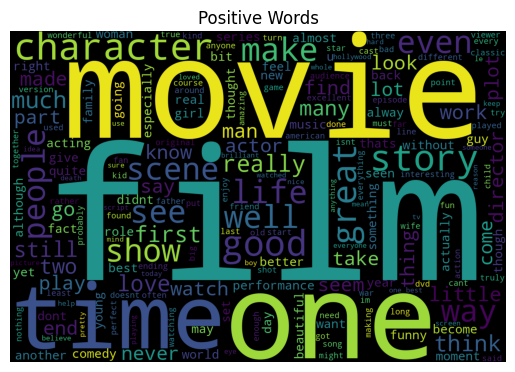

In [ ]:
plt.imshow(wc)
plt.title("Positive Words")
plt.axis("off")
plt.show()

In [ ]:
positive_words_frequency = Counter(tokens)
ps_f=positive_words_frequency.most_common(30)

In [ ]:
data = pd.DataFrame(ps_f,columns=['word','freq']).sort_values('freq',ascending=False)

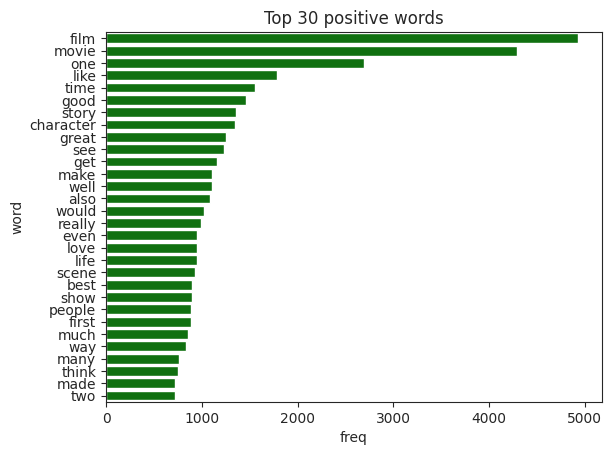

In [ ]:
sns.set_style("ticks")
sns.barplot(x="freq",y='word',data=data,color='g').set(title='Top 30 positive words')

plt.show()

### Negative sentiment

In [ ]:
tokens = str(list(transformed_data[transformed_data.sentiment=='negative'].t_rev)).split()

In [ ]:
neg_words = (" ").join(tokens)

In [ ]:
wc = WordCloud(height=800,width=1200).generate(neg_words)

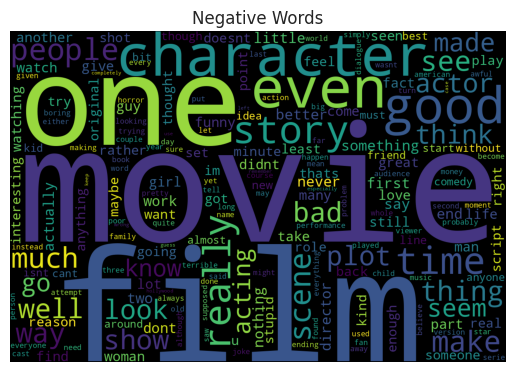

In [ ]:
plt.imshow(wc)
plt.title("Negative Words")
plt.axis("off")
plt.show()

In [ ]:
negative_words_frequency = Counter(tokens)

In [ ]:
neg_f = negative_words_frequency.most_common(30)

In [ ]:
data = pd.DataFrame(neg_f,columns=['word','freq']).sort_values('freq',ascending=False)

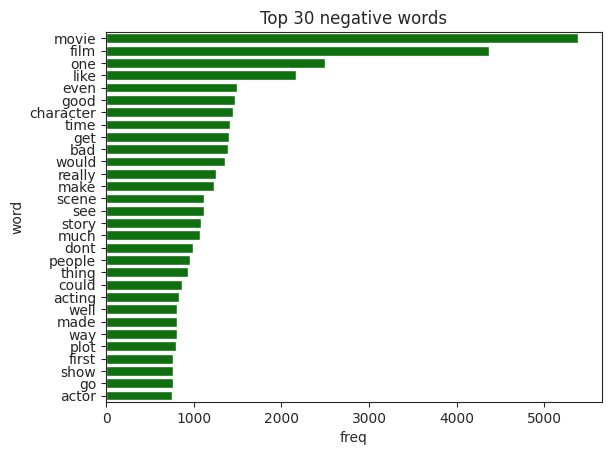

In [ ]:
sns.barplot(x="freq",y='word',data=data,color='g').set(title='Top 30 negative words')

plt.show()

In [ ]:
tf =TfidfVectorizer()
cv=CountVectorizer()

In [ ]:
lb=LabelEncoder()
X = tf.fit_transform(tranformed_rev).toarray()
y= lb.fit_transform(df.sentiment)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state = 42,stratify=y)

### Selecting Model

In [ ]:
models={'lr':LogisticRegression(),
       'rf':RandomForestClassifier(),
       'gs':GaussianNB(),
       'knn':KNeighborsClassifier(),
        'xgb':XGBClassifier()
       }

def fit_predict(models,X_train,y_trian,X_test,y_test):
    y_pred=[]
    models_name=[]
    for model_name,model_obj in models.items():
        model_obj.fit(X_train,y_trian)
        print(f'{model_name} done....')
        y_pred.append(model_obj.predict(X_test))
        models_name.append(model_name)
    return y_pred , models_name

def get_score(y_pred,y_test):
    score=[accuracy_score(y_test,y) for y in y_pred]
    return score

In [ ]:
y_pred , models_name = fit_predict(models,X_train,y_train,X_test,y_test)

lr done....
rf done....
gs done....
knn done....
xgb done....


In [ ]:
score = get_score(y_pred,y_test)

In [ ]:
md_scores = pd.DataFrame({'models':models_name,'score':score}).sort_values("score",ascending=False)

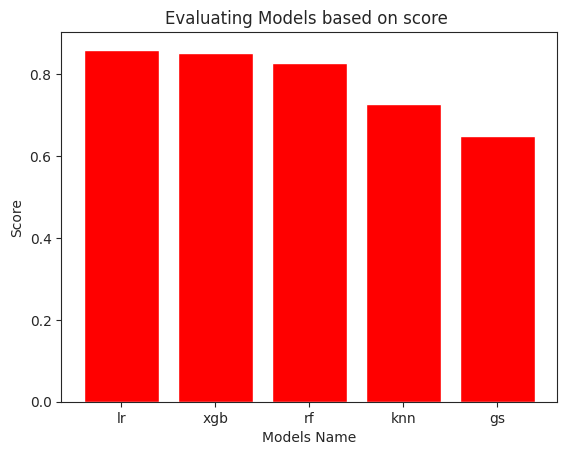

In [ ]:
plt.bar('models','score',color='red',data=md_scores)
plt.title('Evaluating Models based on score ')
plt.xlabel('Models Name')
plt.ylabel('Score')
plt.show()

The best model is Losgistic Regression

### Randomized Search

In [ ]:
lr = LogisticRegression(penalty='l2',solver='newton-cg',random_state=42)

In [ ]:
params = {'C':[7,8,9,10,11,12,13,14],'max_iter':[100,300,500,700,800,1000]}
rm = RandomizedSearchCV(lr,params,verbose=3,cv=5)
rm.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ................C=11, max_iter=300;, score=0.849 total time=  18.5s
[CV 2/5] END ................C=11, max_iter=300;, score=0.850 total time=  18.8s
[CV 3/5] END ................C=11, max_iter=300;, score=0.869 total time=  18.1s
[CV 4/5] END ................C=11, max_iter=300;, score=0.853 total time=  18.2s
[CV 5/5] END ................C=11, max_iter=300;, score=0.848 total time=  17.5s
[CV 1/5] END ................C=13, max_iter=300;, score=0.849 total time=  18.0s
[CV 2/5] END ................C=13, max_iter=300;, score=0.850 total time=  20.7s
[CV 3/5] END ................C=13, max_iter=300;, score=0.865 total time=  18.3s
[CV 4/5] END ................C=13, max_iter=300;, score=0.851 total time=  17.9s
[CV 5/5] END ................C=13, max_iter=300;, score=0.849 total time=  20.4s
[CV 1/5] END ................C=9, max_iter=1000;, score=0.849 total time=  19.5s
[CV 2/5] END ................C=9, max_iter=1000;

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(random_state=42,
                                                solver='newton-cg'),
                   param_distributions={'C': [7, 8, 9, 10, 11, 12, 13, 14],
                                        'max_iter': [100, 300, 500, 700, 800,
                                                     1000]},
                   verbose=3)

In [ ]:
rm.best_score_

0.8545

In [ ]:
lr= rm.best_estimator_

In [ ]:
#  lr = LogisticRegression(penalty='l2',solver='newton-cg',random_state=42)
lr.fit(X_train,y_train)

LogisticRegression(C=7, max_iter=800, random_state=42, solver='newton-cg')

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[425,  71],
       [ 64, 440]])

### Model Evaluation

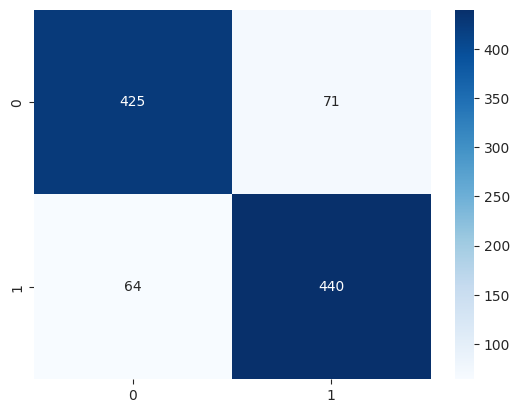

In [ ]:
sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       496
           1       0.86      0.87      0.87       504

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000

